In [130]:
import numpy as np
import sys
sys.path.append("../model")
from rnn_FORCE import RNN
import matplotlib.pyplot as plt
import torch
from torch import tensor
from torch import nn
import seaborn as sns
from torch.autograd.functional import jacobian
SAVEFIG = False

In [131]:
# Initializing matrix
num_nodes = 200
np.random.seed(3)  # 2

connectivity_matrix = np.ones((num_nodes, num_nodes))
weight_matrix = np.random.normal(0, 1/np.sqrt(num_nodes), (num_nodes, num_nodes))
for i in range(num_nodes):
    weight_matrix[i, i] = 0
    connectivity_matrix[i, i] = 0
output_weight_matrix = np.random.uniform(-1, 1, (1, num_nodes))
feedback_weight_matrix = np.random.uniform(-1, 1, (num_nodes, 1)) # * 0.5
init_state = np.random.uniform(-0.5, 0.5, (num_nodes, 1))
init_gain = np.ones((num_nodes, 1))
init_shift = np.zeros((num_nodes, 1))

In [132]:
# Dale's Law
excite_perc = 0.5
excite_num = int(excite_perc*num_nodes)
node_type = np.array([1]*excite_num + [-1]*(num_nodes-excite_num))
weight_type = np.tile(node_type, num_nodes).reshape(num_nodes, -1)

# Enforce Dale's Law
weight_matrix = np.abs(weight_matrix) * weight_type
output_weight_matrix = np.abs(output_weight_matrix) * node_type

# normalize
ext_weight_sum = num_nodes/4
inh_weight_sum = num_nodes/4
tmp_output_weight_matrix = output_weight_matrix.copy()
tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
output_weight_matrix = tmp_output_weight_matrix.copy()
init_output_weight_matrix = output_weight_matrix.copy()

In [133]:
# define targets
time_points = np.arange(6000)
# targets = (np.sin((time_points+1)/60*np.pi))/4 + 0.5
targets = ((np.sin((time_points + 40)/60*np.pi))/4 + 0.5)

# inputs with different phases
np.random.seed(2)
inputs = []
for i in range(num_nodes):
    this_input = (np.sin((time_points + np.random.randint(0, 120))/60*np.pi))/4 + 0.5
    inputs.append(this_input)
inputs = np.array(inputs)

In [134]:
# define sigmoid
def sigmoid_np(x):
    return 1 / (1 + np.exp(-x))

def inv_sigmoid_np(x):
    return -np.log((1 / x) - 1)

Must use activation as x rather than state. Otherwise, the output would not be a linear readout and depend on u.

In [135]:
# imitate rnn_FORCE
class mysys():
    def __init__(self, weight_matrix, connectivity_matrix, gain, shift, input_weight_matrix=None, inputs=None):
        # core parameters
        self.weight_matrix = weight_matrix
        self.connectivity_matrix = connectivity_matrix
        self.gain = gain
        self.shift = shift
        self.inputs = inputs
        self.input_weight_matrix = input_weight_matrix
        self.activation_func = nn.Sigmoid()
        
        # transfer into tensor
        self.weight_matrix_tensor = tensor(self.weight_matrix)
        self.gain_tensor = tensor(self.gain)
        self.shift_tensor = tensor(self.shift)
        
        # constants
        self.time_const = 1
        self.timestep = 0.1
        self.c = self.timestep / self.time_const
        self.g = 1.5
        self.i = 0

    def f_tensor(self, x_tensor, u_tensor, r_tensor):
        # this_input_tensor = torch.matmul(tensor(self.input_weight_matrix), tensor([[self.inputs[self.i]]]))
        y_tensor = (1 - self.c) * x_tensor \
            + self.c * self.activation_func((self.gain_tensor + u_tensor) * (self.g * torch.matmul(self.weight_matrix_tensor, x_tensor) + r_tensor - self.shift_tensor))
        return y_tensor
     
    def f(self, x, u, r):
        x_tensor = tensor(x)
        u_tensor = tensor(u)
        r_tensor = tensor(r)
        y_tensor = self.f_tensor(x_tensor, u_tensor, r_tensor)
        y = y_tensor.numpy()
        return y
    
    def jacob(self, x, u, r):
        x_tensor = tensor(x)
        u_tensor = tensor(u)
        r_tensor = tensor(r)
        dydx, dydu, dydr = jacobian(self.f_tensor,(x_tensor, u_tensor, r_tensor))
        Jx_tensor = dydx.squeeze(dim=(1,3))
        Ju_tensor = dydu.squeeze(dim=(1,3))
        Jr_tensor = dydr.squeeze(dim=(1,3))
        Jx = Jx_tensor.numpy()
        Ju = Ju_tensor.numpy()
        Jr = Jr_tensor.numpy()
        return Jx, Ju, Jr

# jnn_ff = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift, input_weight_matrix=feedback_weight_matrix, inputs=targets)
# jnn = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift, input_weight_matrix=feedback_weight_matrix, inputs=targets)
jnn_ff = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift)
jnn = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift)

### Simulate Without Control

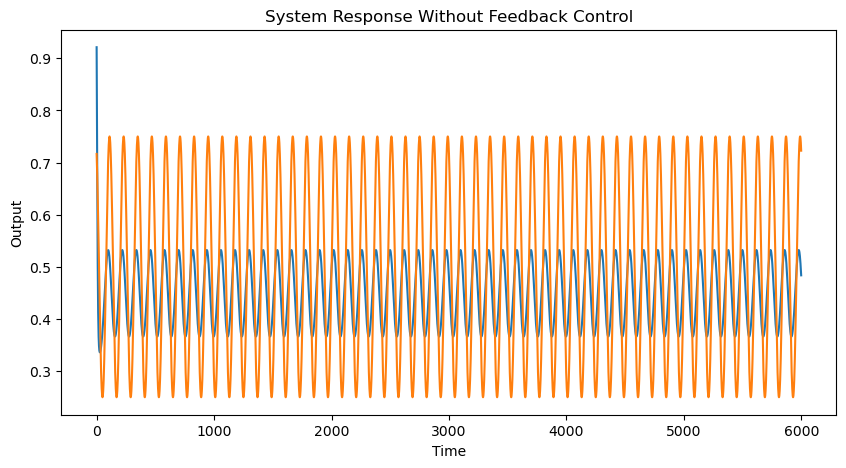

In [136]:
# Simulation Without Control
x = sigmoid_np(init_gain * init_state.copy() - init_shift)
u = init_state.copy() * 0
xs_ff_init, outputs_ff_init = [x], []
gainout= 2.5 # 1.15
shiftout= -2 # -2.5

for i in time_points[:-1]:
    
    # jnn_ff.i = i

    # output
    output_beforesig = output_weight_matrix @ x
    output = sigmoid_np(gainout * output_beforesig - shiftout)

    # input
    this_input = inputs[:,i]
    r = feedback_weight_matrix * this_input.reshape(-1,1)

    # update x
    x1 = jnn_ff.f(x, u, r)
    x = x1.copy()
    
    # save
    xs_ff_init.append(x)
    outputs_ff_init.append(output.item())

# final readout for x_T
output_beforesig = output_weight_matrix @ x
output = sigmoid_np(gainout * output_beforesig - shiftout)
outputs_ff_init.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff_init)
plt.plot(time_points, targets)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

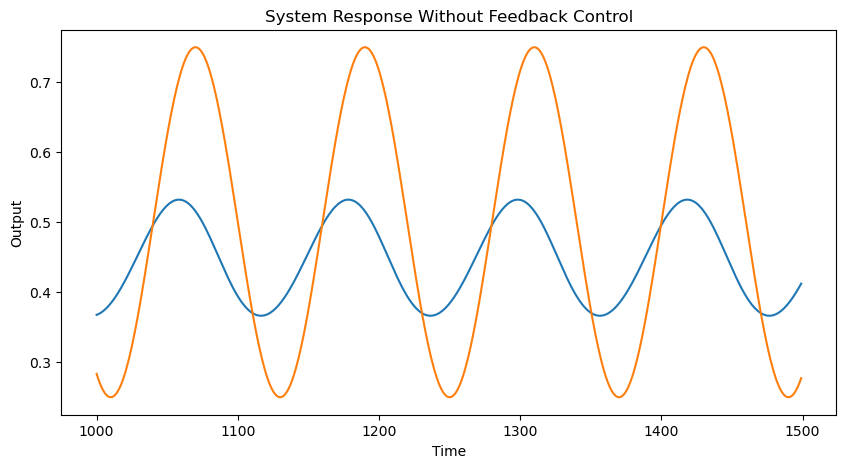

In [137]:
# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points[1000:1500], outputs_ff_init[1000:1500])
plt.plot(time_points[1000:1500], targets[1000:1500])
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

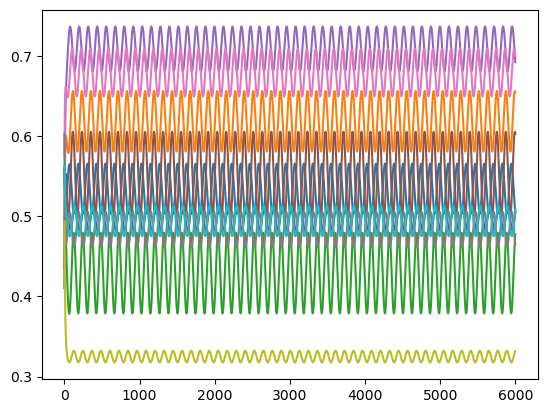

In [138]:
all_xs_ff_init = np.concatenate(xs_ff_init, axis=1)
for i in range(10, 20):
    plt.plot(all_xs_ff_init[i,:], label=f"Node {i}")

In [139]:
peaks = []
for i in range(num_nodes):
    y = all_xs_ff_init[i]
    p = np.argmax(y[500:620])
    peaks.append(p)
target_peak = np.argmax(targets[500:620])
relative_peaks_ff_init = np.array(peaks) - target_peak

# plus 120 for relative peaks less than 0
relative_peaks_ff_init[relative_peaks_ff_init < 0] += 120
relative_peaks_ff_init

array([ 73,  29,   2,  36,   9,   8,  89,  29,   7, 104,  76,   3,  14,
        30,  86,   3, 114,  79,  16,  23, 116,   7,  80,  38,  62, 110,
        65,  36,  52,   1,  10,  57,  18, 117, 117,  19,  82,   7,   4,
       102,  13,  89,  16, 105,  25,  10,   3, 105,  58,  45,  19,  42,
        91,  56, 116,  62,  38,  53,   6,  30,  58,  14, 110, 113,  29,
        26,  48,  22,  53,   4, 115,  84, 107, 118,  10,  60, 102,  12,
       117,  39,  28,  40,  69,  12,  49,  15, 111,   7, 101,  83, 104,
        23, 117,  30, 116, 101,  67,  93, 108, 104,  72,  73, 104,  94,
        17,  94,  85,  73,  55,   7,  31,  38,  78,  10,  80,   8,  30,
         0,  50,  35,  66,  15,  97,  71,  13,  34,  15,  46,  29,  30,
        83,  33,  95,   6,   4,   0,   6,  93,  48,  27,  52,  17,   9,
        85,  46,  44,  11,  42, 111,  15,  73,  43, 100,   2,   1,  34,
       110,   3,  86,  42,  25,  78,  60,  16,   6,  60,  68,  60,  56,
        16,  33,   3,  97,  74,   5,  82, 116, 117,  24,   9,   

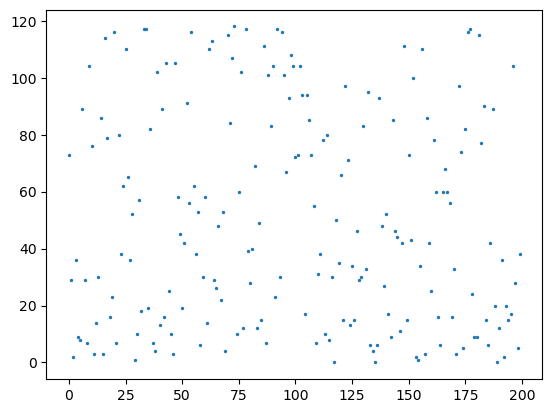

In [140]:
plt.scatter(np.arange(num_nodes), relative_peaks_ff_init, s=2)

### Discrete Tracking Control

In [14]:
# calculate the desired output before the output sigmoid
gainout= 1.15
shiftout= 2 # -2.5
y_tildes = (inv_sigmoid_np(targets) + shiftout) / gainout

In [15]:
# Simulate with control
x = init_state.copy()
u = init_state.copy() * 0
xs_fb, us_fb, outputs_fb_beforesig, outputs_fb = [x], [], [], []

# constants
R = np.eye(num_nodes) * 0.0001
Q1 = np.eye(num_nodes) * 0.01
Q2 = np.eye(1) * 10

for t in time_points[:-1]:

    # jnn.i = t

    # output
    output_beforesig = output_weight_matrix @ x
    output = sigmoid_np(gainout * output_beforesig - shiftout)

    # input
    this_input = inputs[:,t]
    r = feedback_weight_matrix * this_input.reshape(-1,1)
    
    # linear approxmation of nonlinear system
    # linear approximate F and G
    F, G, _ = jnn.jacob(x, u, r)   # x_t, u_t-1
    c = jnn.f(x, u, r) - F @ x - G @ u  # the constant term after approximation
    # augment the system for the constant term
    F_aug = np.concatenate([np.concatenate([F, np.eye(num_nodes)], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    G_aug = np.concatenate([G, np.zeros((num_nodes, num_nodes))], axis=0)
    x_aug = np.concatenate([x, c], axis=0)

    # get H
    H = output_weight_matrix.T
    L = H @ np.linalg.inv(H.T @ H)
    H_bar = (np.eye(num_nodes) - L @ H.T).T
    Q = H_bar @ Q1 @ H_bar.T + H @ Q2 @ H.T
    y_tilde = y_tildes[t+1]
    x_tilde = L @ np.array([[y_tilde]])
    x_tilde_aug = np.concatenate([x_tilde, c], axis=0)
    # Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.zeros((num_nodes, num_nodes))], axis=1)], axis=0)

    # get the control input u
    # backward solve
    S_t2 = Q_aug
    b_t2 = np.zeros(shape=(2 * num_nodes, 1))
    S_t1 = F_aug.T @ (S_t2 - S_t2 @ G_aug @ np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2) @ F_aug + Q_aug
    K_T_t1 = -np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2 @ F_aug
    b_t1 = (F_aug.T + K_T_t1.T @ G_aug.T) @ b_t2 - Q_aug @ x_tilde_aug
    # calculate u_t
    u1 = -np.linalg.inv(G_aug.T @ S_t1 @ G_aug + R) @ G_aug.T @ (S_t1 @ F_aug @ x_aug + b_t1)
    # u = np.linalg.pinv(G) @ (G @ u1 - B @ r)
    # update u
    u = u1.copy()
    
    # update x
    x1 = jnn.f(x, u, r)
    # x1_0 = F @ x + G @ u + c
    # x1_1 = F_aug @ x_aug + G_aug @ u
    # print(np.linalg.norm(x1_0-x1))
    # print(np.linalg.norm(x1_1[0:num_nodes,:]-x1))
    x = x1.copy()
    
    # save
    xs_fb.append(x)
    us_fb.append(u)
    outputs_fb_beforesig.append(output_beforesig.item())
    outputs_fb.append(output.item())

# final readout for x_T
output_beforesig = output_weight_matrix @ x
output = sigmoid_np(gainout * output_beforesig - shiftout)
outputs_fb_beforesig.append(output_beforesig.item())
outputs_fb.append(output.item())

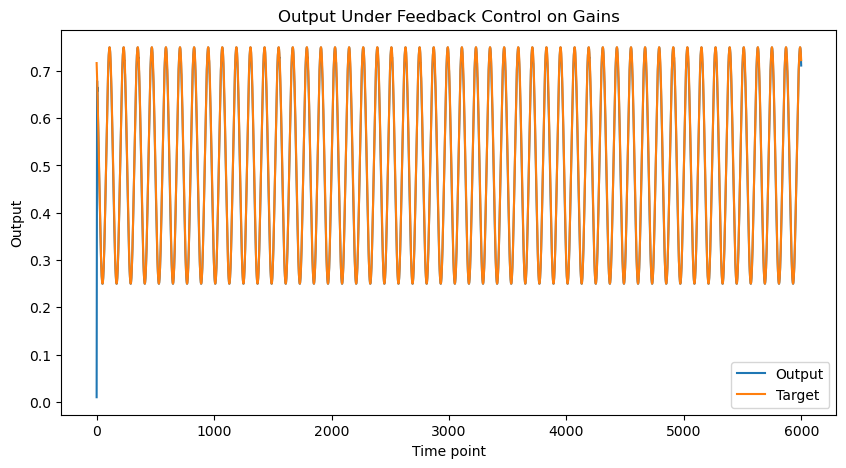

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_fb, label='Output')
plt.plot(time_points,targets, label='Target')
plt.title('Output Under Feedback Control on Gains')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_tracking_output.png")

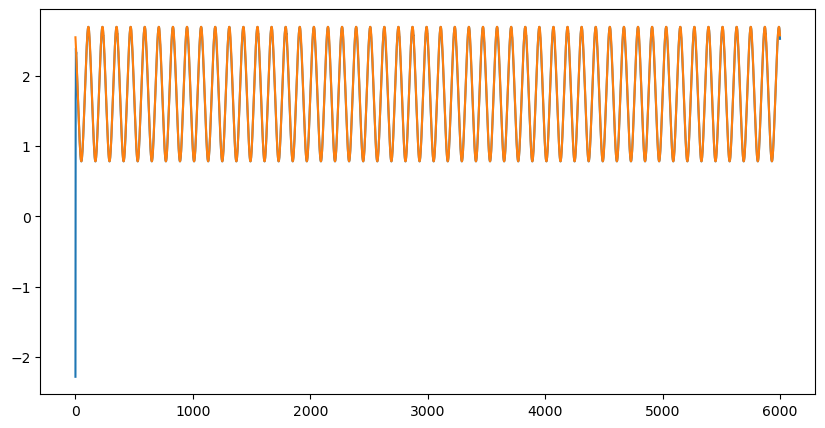

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(outputs_fb_beforesig)
plt.plot(y_tildes)

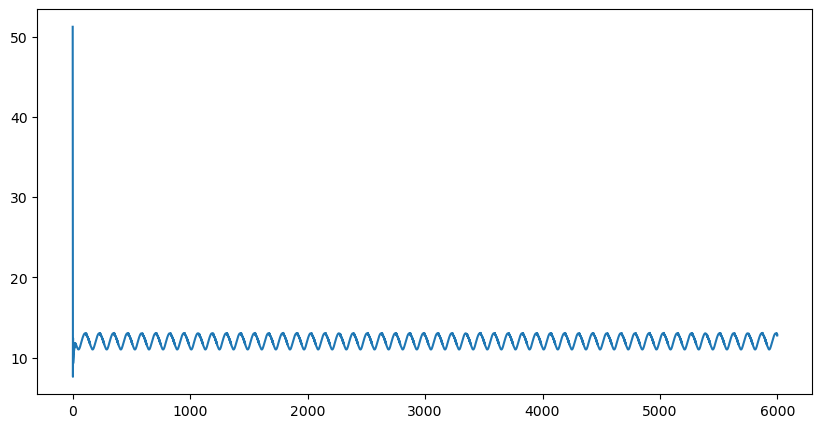

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
us_norm = [np.linalg.norm(u) for u in us_fb]
plt.plot(us_norm)

### Discrete Tracking Control Plus Hebbian Learning

In [142]:
# calculate the desired output before the output sigmoid
gainout= 2.5 # 1.15
shiftout= -2 # -2.5
y_tildes = (inv_sigmoid_np(targets) + shiftout) / gainout

In [143]:
# Simulate with control
x = init_state.copy()
u = init_state.copy() * 0
this_output_weight_matrix = output_weight_matrix.copy()
xs_hebb, us_hebb, outputs_hebb_beforesig, outputs_hebb = [x], [], [], []
has_hebbian = False

# constants
R = np.eye(num_nodes) * 0.0001
Q1 = np.eye(num_nodes) * 0.01
Q2 = np.eye(1) * 10
hebbian_lr = 0.01

for t in time_points[:-1]:

    # jnn.i = t

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * output_beforesig - shiftout)

    # update readout weights by hebbian learning
    if not has_hebbian and t > 1000:
        has_hebbian = True
        x_mean = np.concatenate(xs_hebb, axis=1).mean(axis=1).reshape(-1, 1)
        x_std = np.concatenate(xs_hebb, axis=1).std(axis=1).reshape(-1, 1)
        # output_mean = np.array(outputs_fb).mean()
        output_mean = 0.5
        # target_mean = 0.5
    if has_hebbian:
        # this_target = targets[t]
        # Calculate Hebbian weight updates
        # hebbian_update = (this_target - target_mean) * ((x - x_mean) / x_std).T
        hebbian_update = (output - output_mean) * ((x - x_mean) / x_std).T
        # hebbian_update = output * x.T
        # hebbian_update = hebbian_update * node_type
        # Normalized Hebbian learning
        tmp_output_weight_matrix = this_output_weight_matrix + hebbian_lr * hebbian_update
        tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
        tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
        tmp_ext[tmp_ext < 0] = 0
        tmp_inh[tmp_inh > 0] = 0
        tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
        tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
        tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
        tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
        # update init weights
        this_output_weight_matrix = tmp_output_weight_matrix.copy()

    # input
    this_input = inputs[:,t]
    r = feedback_weight_matrix * this_input.reshape(-1,1)
    
    # linear approxmation of nonlinear system
    # linear approximate F and G
    F, G, _ = jnn.jacob(x, u, r)   # x_t, u_t-1
    c = jnn.f(x, u, r) - F @ x - G @ u  # the constant term after approximation
    # augment the system for the constant term
    F_aug = np.concatenate([np.concatenate([F, np.eye(num_nodes)], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    G_aug = np.concatenate([G, np.zeros((num_nodes, num_nodes))], axis=0)
    x_aug = np.concatenate([x, c], axis=0)

    # get H
    H = this_output_weight_matrix.T
    L = H @ np.linalg.inv(H.T @ H)
    H_bar = (np.eye(num_nodes) - L @ H.T).T
    Q = H_bar @ Q1 @ H_bar.T + H @ Q2 @ H.T
    y_tilde = y_tildes[t+1]
    x_tilde = L @ np.array([[y_tilde]])
    x_tilde_aug = np.concatenate([x_tilde, c], axis=0)
    # Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.zeros((num_nodes, num_nodes))], axis=1)], axis=0)

    # get the control input u
    # backward solve
    S_t2 = Q_aug
    b_t2 = np.zeros(shape=(2 * num_nodes, 1))
    S_t1 = F_aug.T @ (S_t2 - S_t2 @ G_aug @ np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2) @ F_aug + Q_aug
    K_T_t1 = -np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2 @ F_aug
    b_t1 = (F_aug.T + K_T_t1.T @ G_aug.T) @ b_t2 - Q_aug @ x_tilde_aug
    # calculate u_t
    u1 = -np.linalg.inv(G_aug.T @ S_t1 @ G_aug + R) @ G_aug.T @ (S_t1 @ F_aug @ x_aug + b_t1)
    # update u
    u = u1.copy()
    
    # update x
    x1 = jnn.f(x, u, r)
    # x1_0 = F @ x + G @ u + c
    # x1_1 = F_aug @ x_aug + G_aug @ u
    # print(np.linalg.norm(x1_0-x1))
    # print(np.linalg.norm(x1_1[0:num_nodes,:]-x1))
    x = x1.copy()
    
    # save
    xs_hebb.append(x)
    us_hebb.append(u)
    outputs_hebb_beforesig.append(output_beforesig.item())
    outputs_hebb.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * output_beforesig - shiftout)
outputs_hebb_beforesig.append(output_beforesig.item())
outputs_hebb.append(output.item())

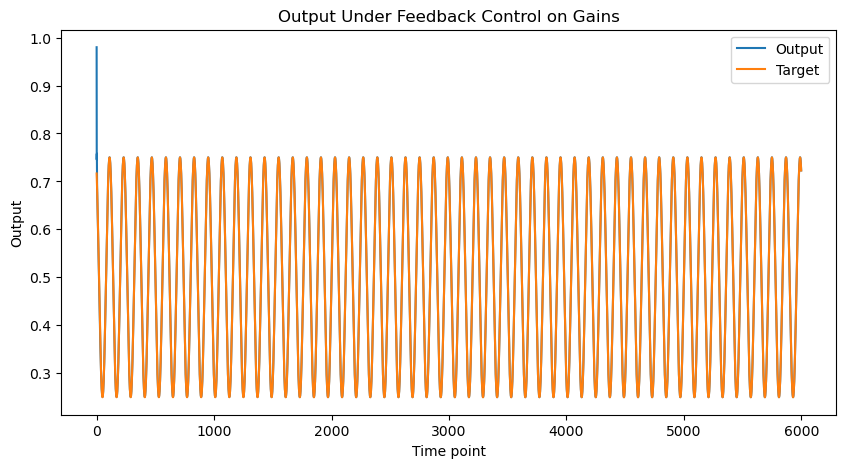

In [144]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_hebb, label='Output')
plt.plot(time_points, targets, label='Target')
plt.title('Output Under Feedback Control on Gains')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_tracking_output.png")

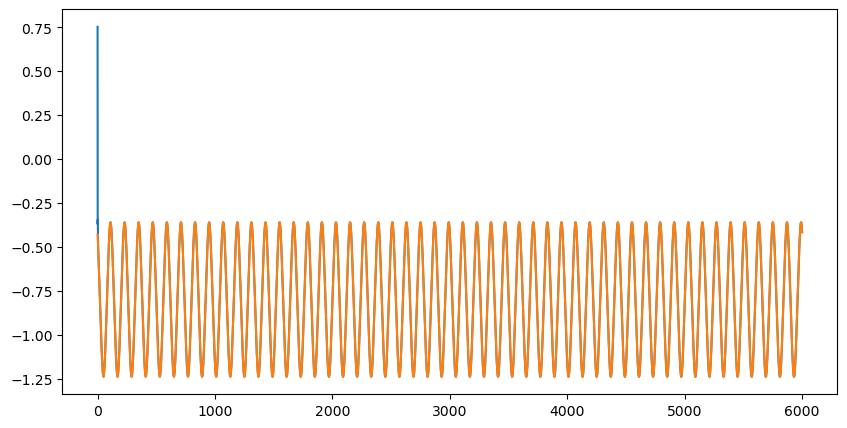

In [145]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(outputs_hebb_beforesig)
plt.plot(y_tildes)

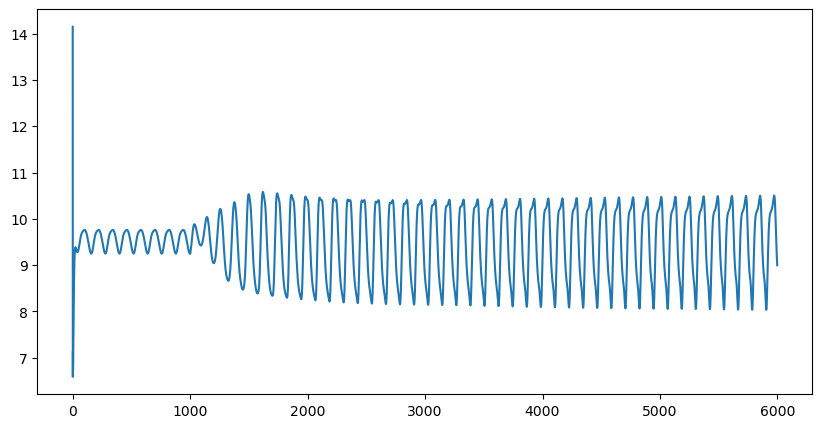

In [146]:
fig, ax = plt.subplots(figsize=(10, 5))
us_norm = [np.linalg.norm(u) for u in us_hebb]
plt.plot(us_norm)

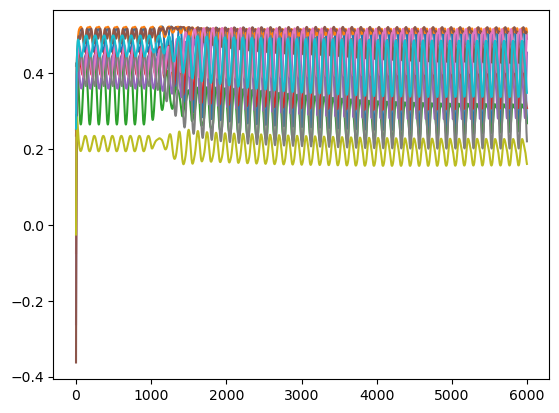

In [147]:
all_xs_hebb = np.concatenate(xs_hebb, axis=1)
for i in range(10, 20):
    plt.plot(all_xs_hebb[i,:], label=f"Node {i}")

In [165]:
peaks = []
start = 5500
end = start + 120
for i in range(num_nodes):
    y = all_xs_hebb[i]
    p = np.argmax(y[start:end])
    peaks.append(p)
target_peak = np.argmax(targets[start:end])
relative_peaks_hebb = np.array(peaks) - target_peak

# plus 120 for relative peaks less than 0
relative_peaks_hebb[relative_peaks_hebb < 0] += 120
relative_peaks_hebb

array([102,  65,  79,  63,  79,  38,  41,  60,  97,  92,  80,  62,  62,
        60,  30,  82,  39,  75,  66,  64,  96,  74,  68,  59,  74,  91,
        64,  73,  67,  74,  59,  35,  28,  73, 104,  74,  88, 101,  97,
        93,  50, 109,  61,  92,  54,  75,  80,  79,  65,  65,  60,  61,
        78,  66,  74,  67,  53,  97,  86,  60,  70,  85,  75,  95,  75,
        53,  14,  63,  59,  92,  96,  85,  78,  79, 103,  68,  76,  71,
        96,  62,  54,  57,  71,  66,  60,  68,  77,  98,  46,  45,  49,
        69,  33,  64,  94,  80,  69, 105,  45, 116, 116,  62,  93,  85,
        61,  93,  80,  69,  58, 102,  68,  62,  75, 108,  34,  68,  49,
        95,  66,  70,  70,  66, 117,  67,  70,  59,  68,  65,  12,  62,
        77,  41,  78, 101,  93,  76, 114,  82,  19,  43,  65,  79, 102,
        74,  74,  63, 100,  73,  93, 109,  76,  63, 119,  97,  98,  53,
        95,  30, 100,  72,  46,  27,  67,  85, 109,  67,  73, 114,  70,
        95, 103,  97,  85, 113,  97, 108,  80,  84,  68,  98,  7

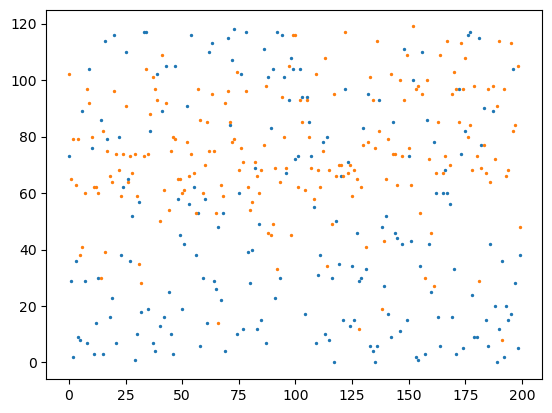

In [166]:
plt.scatter(np.arange(num_nodes), relative_peaks_ff_init, s=2)
plt.scatter(np.arange(num_nodes), relative_peaks_hebb, s=2)

In [150]:
# this_output_weight_matrix = this_output_weight_matrix / x_mean.T / 100

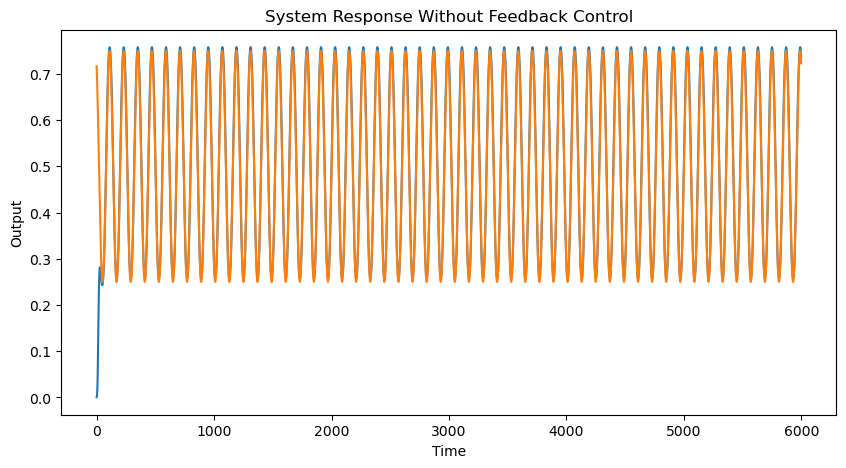

In [161]:
# Simulation Without Control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
u = init_state.copy() * 0
xs_ff_after, outputs_ff_after = [x], []
gainout = 1.1 # 1
shiftout = 5.2 # -1.6

for i in time_points[:-1]:

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # input
    this_input = inputs[:,i]
    r = feedback_weight_matrix * this_input.reshape(-1, 1)
    
    # update x
    x1 = jnn_ff.f(x, u, r)
    x = x1.copy()

    # save
    xs_ff_after.append(x)
    outputs_ff_after.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_ff_after.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff_after)
plt.plot(time_points, targets)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

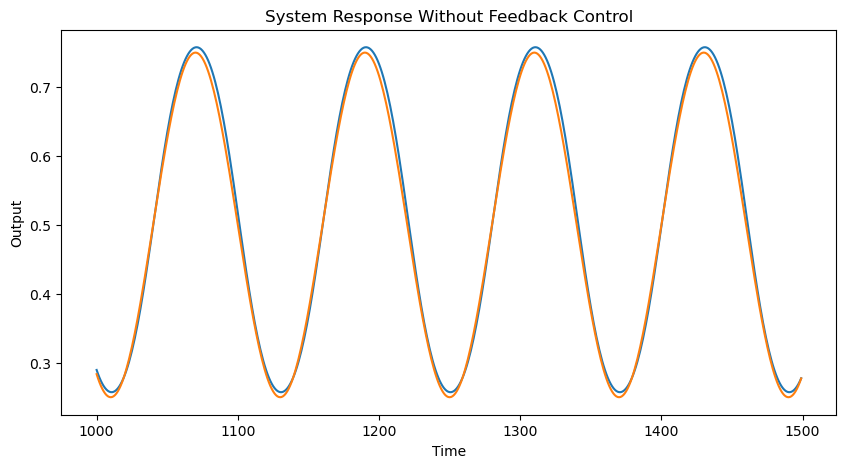

In [162]:
# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points[1000:1500], outputs_ff_after[1000:1500])
plt.plot(time_points[1000:1500], targets[1000:1500])
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

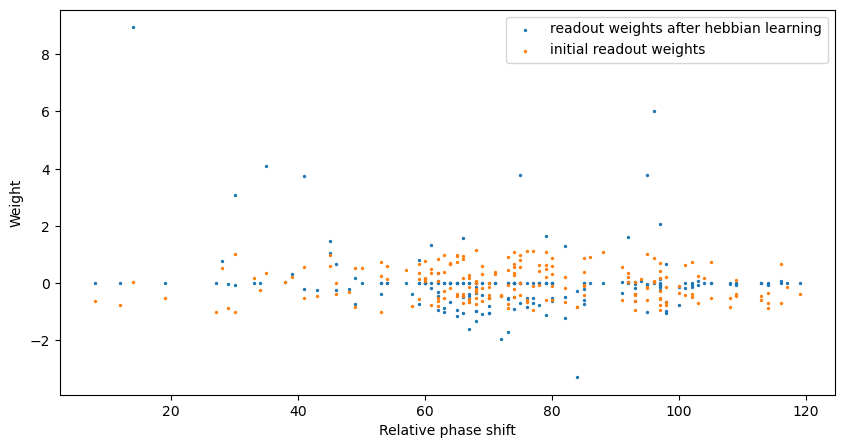

In [167]:
plt.subplots(figsize=(10, 5))
plt.scatter(relative_peaks_hebb, this_output_weight_matrix.flatten(), s=2, label="readout weights after hebbian learning")
plt.scatter(relative_peaks_hebb, output_weight_matrix.flatten(), s=2, label="initial readout weights")
plt.xlabel("Relative phase shift")
plt.ylabel("Weight")
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_phase_outweights.png")

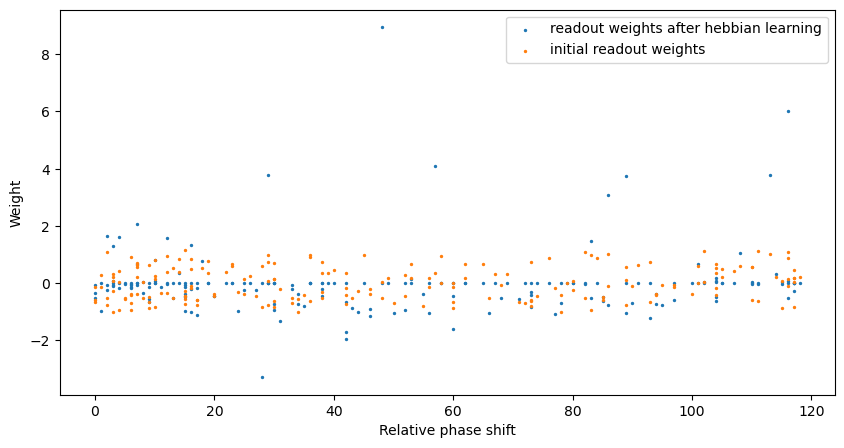

In [169]:
plt.subplots(figsize=(10, 5))
plt.scatter(relative_peaks_ff_init, this_output_weight_matrix.flatten(), s=2, label="readout weights after hebbian learning")
plt.scatter(relative_peaks_ff_init, output_weight_matrix.flatten(), s=2, label="initial readout weights")
plt.xlabel("Relative phase shift")
plt.ylabel("Weight")
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_phase_outweights.png")